In [44]:
import numpy as np
import pandas as pd
import torch
import pickle
import torch.nn as nn
import glob
import transformers
from bs4 import BeautifulSoup
import requests
import re
import random
import time
import matplotlib
import matplotlib.pyplot as plt
from collections import defaultdict
import pdfplumber
from tqdm import tqdm
import collections
from selenium import webdriver
from transformers import DistilBertTokenizer, DistilBertModel
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, Dataset

import sys
sys.path.insert(0, '../src/models/')
sys.path.insert(0, '../src/features/')
import predict_model
from build_features import random_text_splitter as split_text

# Load BERT
model = predict_model.loadBERT("../models/", 'model_weights_splitted_reducednegatives.pt')
# Load the BERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

%matplotlib inline

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


CPU Success


In [2]:
def SpanPredictor(span, pred_values=False):
    
    """
    Uses a trained bert classifier to see if a span
    belongs to a species description or otherwise.
    """
         
    with torch.no_grad():
        # Tokenize input
        inputs = tokenizer(span, return_tensors="pt", truncation=True)
        # Predict class
        outputs = model(inputs['input_ids'], inputs['attention_mask'])
        # Get prediction values
        exps = torch.exp(outputs)
        # Get class
        span_class = exps.argmax(1).item()

        # Print the prediction values
        if pred_values:
            return span_class, exps[0]
        else:
            return span_class    

In [3]:
URL = 'https://en.wikipedia.org/wiki/European_robin'
page = requests.get(URL, timeout=5)
soup = BeautifulSoup(page.content, 'html.parser')

robintext = soup.getText()
robintext_splitted = split_text(robintext)

In [4]:
robin_predictions = [tuple([span, SpanPredictor(span, pred_values=True)]) for span in tqdm(robintext_splitted)]

100%|█████████████████████████████████████████| 151/151 [00:10<00:00, 14.27it/s]


In [5]:
robin_truthlabels = [truthprediction[1][1][1].numpy().item() for truthprediction in robin_predictions]

In [47]:
def highlight_text(sentences, predictions, save=False):
    
    """
    Highlight text based on the predicted value by the 
    description deep learning BERT model.
    """
    

    cmap = matplotlib.cm.get_cmap('Spectral')
    
    # Call figure and add axis
    fig = plt.figure(figsize=(16, 16))
    ax = fig.add_subplot()
    # Set axis
    ax.axis([0, 10, 0, 10])
    ax.axis('off')
    
    y_axis_start = 10
    # Loop over the text
    for count, (sent, pred) in enumerate(zip(sentences, predictions)):
        # Set axis with correct color and align right
        ax.text(0.0, y_axis_start, sent, ha='left',
                bbox={'facecolor': cmap(pred), 'alpha': 0.7, 'pad': 4})
        
        # Update axis start
        y_axis_start -= .2
        
        
                

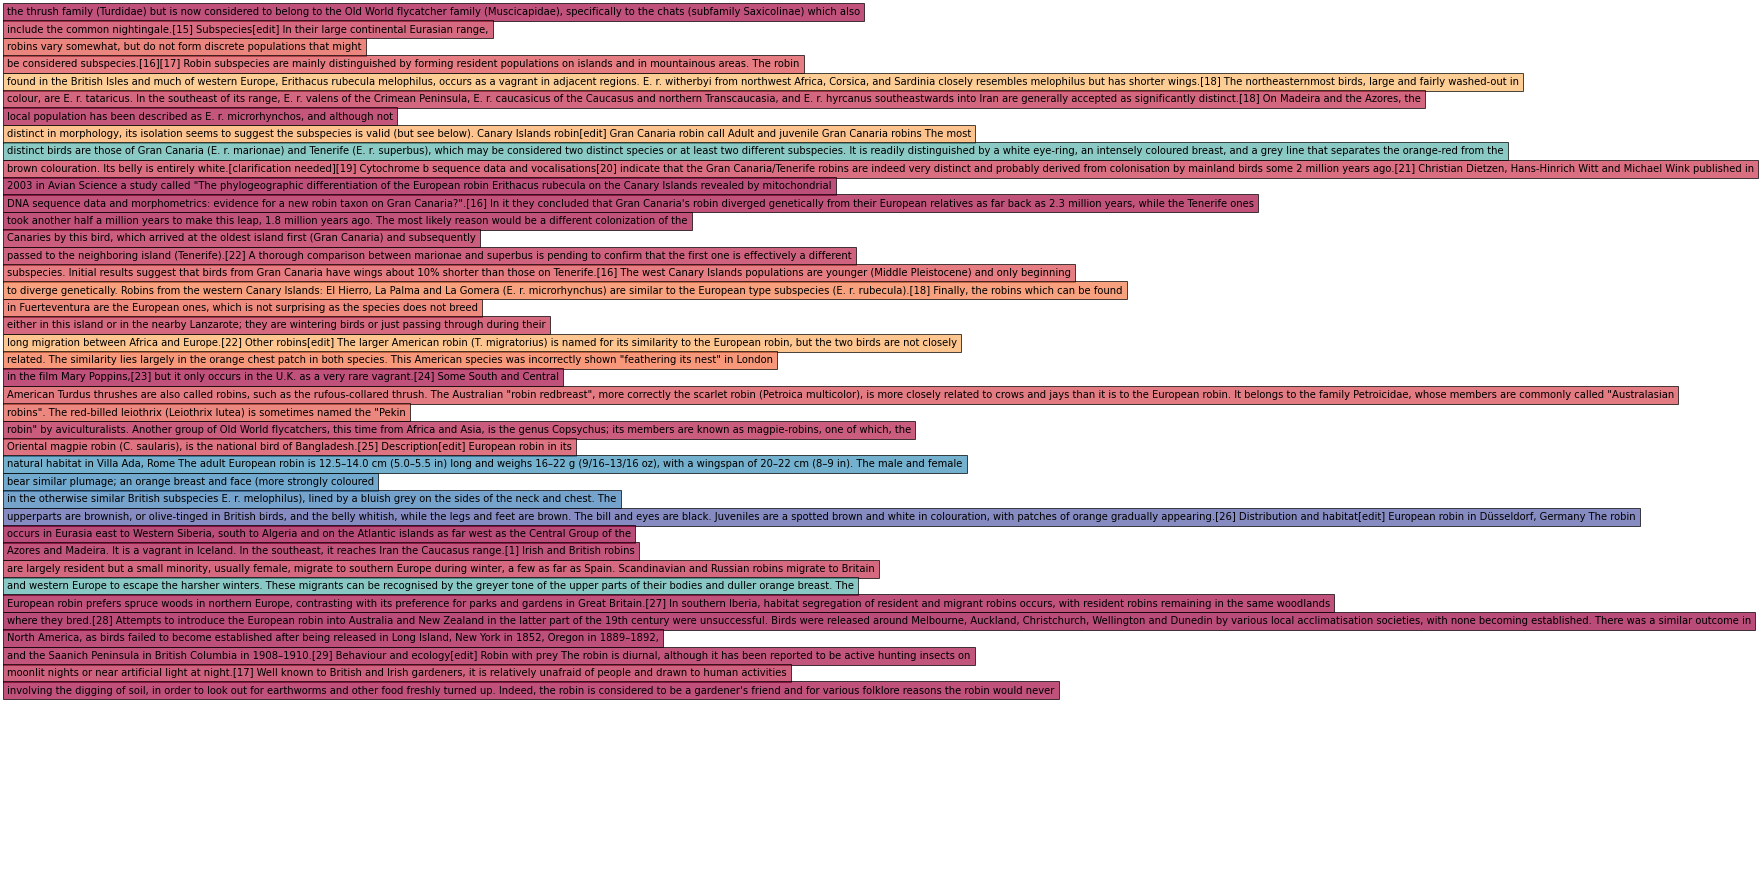

In [48]:
highlight_text(robintext_splitted[20:60], robin_truthlabels[20:60])

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()
ax.axis('off')
ax.text(0.0, 1.0, robintext_splitted[8],  
         verticalalignment='center', ha='right',
         bbox={'facecolor': 'green', 'alpha': robin_truthlabels[8], 'pad': 7})
ax.text(0.0, 1.0, robintext_splitted[9], horizontalalignment='center', 
         verticalalignment='center',
         bbox={'facecolor': 'green', 'alpha': robin_truthlabels[9], 'pad': 7})
ax.text(0.0, 0.80, robintext_splitted[10], horizontalalignment='center', 
         verticalalignment='center',
         bbox={'facecolor': 'green', 'alpha': 1, 'pad': 7})

In [ ]:
len(robintext_splitted[10].split())

In [ ]:
plt.plot(robin_truthlabels, '.')